In [273]:
import pickle
import os,sys,inspect
currentdir = os.path.dirname(
    os.path.abspath(inspect.getfile(inspect.currentframe()))
        )
sys.path.insert(0, os.path.join(currentdir, os.path.pardir, "src/solve"))
sys.path.insert(0, os.path.join(currentdir, os.path.pardir, "src/visualization"))
sys.path.insert(0, os.path.join(currentdir, os.path.pardir, "src/data"))
import lloovia
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [275]:
import matplotlib
# Parámetros de las gráficas para publicación en artículo
sb_white=dict(matplotlib.style.library["seaborn-whitegrid"])
sb_paper=dict(matplotlib.style.library["seaborn-paper"])
my_settings = {
    "axes.titlesize": 8,
    "axes.labelsize": 8,
    "xtick.labelsize": 6,
    "ytick.labelsize": 6,
    "figure.figsize": (3.5, 2.5),
    'grid.linestyle': '-',
    "grid.linewidth": 0.5,
    "grid.alpha": 0.5,
    "lines.markersize": 3,
    "lines.linewidth": 0.8,
    "text.usetex": False,   
    "font.family": "serif",
    "pgf.rcfonts": False,
    "font.serif": [],   
    "font.sans-serif": [],
    "font.monospace": [],
}
paper_style = {}
for x in [sb_white, sb_paper, my_settings]:
    paper_style.update(x)
    
# Parámetros para verlas en el notebook
notebook_style = {}
my_settings = {
   "figure.figsize": (7, 5)
}
for x in [dict(matplotlib.style.library["seaborn-darkgrid"]),
          dict(matplotlib.style.library["seaborn-notebook"])]:
    notebook_style.update(x)

# All experiments in a single dataframe

In [356]:
df = pd.read_pickle("../data/processed/all_experiments_result.pickle")

In [358]:
df.head()

cost  seconds_to_solve  \
Case       Base level Phase max_bins                               
Decreasing 50000      I     5         1677.188          0.048798   
                            10        1591.275          0.048770   
                            20        1586.235          0.106694   
                            40        1552.076          0.235922   
                            80        1538.414          0.328339   

                                      seconds_to_create frac_gap  max_seconds  \
Case       Base level Phase max_bins                                            
Decreasing 50000      I     5                  0.014099     0.01        900.0   
                            10                 0.026420     0.01        900.0   
                            20                 0.050764     0.01        900.0   
                            40                 0.111839     0.01        900.0   
                            80                 0.232213     0.01        900.0   

                                       status  
Case       Base level Phase max_bins           
Decreasing 50000      I     5         optimal  
                            10        optimal  
                            20        optimal  
                            40        optimal  
                            80        optimal

Some general statistics about the number of solved/aborted experiments, per phase. 

In [357]:
df.reset_index().groupby("Phase").status.value_counts()

Phase  status  
I      optimal     294
       aborted      42
II     optimal     281
O      aborted      14
       optimal      14
R      optimal      27
       overfull      1
Name: status, dtype: int64

The meaning of the letters in "Phase" column is as follows:

* `I`
  : Phase I solved for different `max_bins` values, including a "nobins" case

* `II`
  : Phase II solved after the solutions of Phase I, using as STWP the same traces than the ones used in Phase I as LTWP. This simulates a "Perfect Prediction" case.

* `R`
  : Phase II solved after the solutions of Phase I, but using as STWP a new set of traces, generated with the same parameters than the ones in Phase I. This simulates an "slightly imperfect prediction".

* `O`
  : Oracle for the case **R**, provides the optimal solution if the STWP were knonw in advance. It is found by solving a Phase I using that STWP as LTWP, without binning.

# Phase I

## Graphics of solving time

In [338]:
# Función extraida de otro libro, sin tocar salvo para cambiar la Phase de 1 a "I"
def time_plot(all_data, case, level, 
              ax=None, legend=True, title=True, plot_phase_II=True):
    # Extraer la solución para este caso y level
    data = all_data.loc[(case, level, "I"), 
                        ["seconds_to_create", "seconds_to_solve", "status"]
                       ].reset_index()
    
    if title:
        title="{} {}".format(case, level)
    else:
        title=""
    labels = ["sec to create", "sec to solve"]
    ax = data.plot(x="max_bins", y="seconds_to_create",
                   title=title, marker="o", #ls="--", dashes=(1,1),
                   ax=ax, legend=legend)
    ax = data.plot(x="max_bins", y="seconds_to_solve",
                  marker="s", ls="solid",
                  ax=ax, legend=legend)
    
    if plot_phase_II:
        data2 = all_data.loc[(case, level, 2), 
                ["seconds_to_create", "seconds_to_solve"]].reset_index()
        data2.plot(x="max_bins", y=["seconds_to_create", "seconds_to_solve"], 
                         marker="s", markersize=3, ax=ax, legend=legend)
        labels = [x + " I" for x in labels]
        labels+= ["sec to create II", "sec to solve II"]

    aborted = data[data.status.str.contains("aborted")]
    if len(aborted):
        aborted.plot(ax=ax, x="max_bins", y=["seconds_to_solve"], 
                     linestyle="", color="y", 
                     marker = "D", markerfacecolor="white",
                     markeredgecolor="k", 
                     markeredgewidth=0.5,
                     legend=legend)
        labels+=["aborted"]
        
    ax.set_yscale("log")
    ax.set_xscale("log")
    requested_bins = [int(x) for x in data.max_bins.tolist()]
    requested_bins = [5, 20, 80, 400, 1600, 8760]
    ax.set_xticks(requested_bins)
    ax.set_xticklabels(requested_bins[:-1] + ["No bins"], rotation='vertical')
    ax.set_xlabel("Bins")
    ax.set_yticks([0.1, 1, 10, 60, 60*10, 60*60])
    ax.set_yticklabels(["0.1s", "1s", "10s", "1min", "10min", "1h"])
    ax.set_ylim(0,60*80)
    ax.set_xlim(0,10000)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    if legend:
        L=ax.legend(labels=labels, loc="best")
    return ax

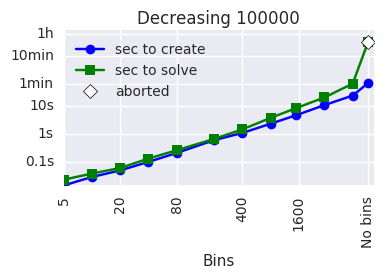

In [339]:
with matplotlib.style.context(notebook_style):
    time_plot(df, "Decreasing", 100000, plot_phase_II=False)
    plt.gcf().set_size_inches((4,2))

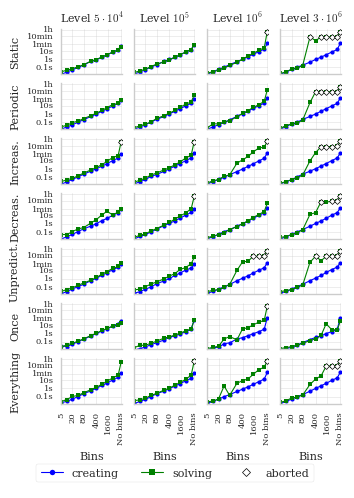

In [340]:
# Preparo qué casos quiero mostrar (y en qué orden)
casetitles = ["Static", "Periodic", "Increasing", "Decreasing",
              "Unpredictable", "Once", "Everything"]

#casetitles = ["Increasing", "Decreasing"]
levels = [5,10,100,300]
# Preparo un array de subplots
with matplotlib.style.context(paper_style):
    f, axarr = plt.subplots (len(casetitles), len(levels), sharex=True, 
                             sharey=True, figsize=(15,30))

    # Hago el plot de cada caso, cada uno en su subplot correspondiente
    for i,case in enumerate(casetitles):
        for j,level in enumerate(levels):
            a = time_plot(df, case, level*10000, 
                                   ax=axarr[i,j], legend=False, title=False, 
                                   plot_phase_II=False)        
    f.set_size_inches(3.5,5)
    # f.tight_layout()

    # Pongo títulos a filas y columnas
    for ax, casetitle in zip(axarr[:,0], 
            ["Static", "Periodic", "Increas.", "Decreas.", "Unpredict.", "Once", "Everything"]):
        ax.set_ylabel(casetitle, rotation=90)
    for ax, level in zip(axarr[0,:], ["5\cdot10^4", "10^5", "10^6", "3\cdot10^6" ]):
        ax.set_title("Level ${}$".format(level))

    patches, labels = axarr[-1,-1].get_legend_handles_labels()
    f.legend(patches, labels=["creating", "solving", "aborted"], 
             bbox_to_anchor=(0.5, 0.05), loc="center",
             markerscale=1.3,
             ncol=3, shadow=False, fancybox=True, framealpha=0.8, 
             frameon=True)
    f.subplots_adjust(bottom=0.2, left=0.15,right=0.95, top=0.95)

# Phase II (Perfect Prediction)

## Overcost for different binnings

In [341]:
import itertools
for case, level in itertools.product(df.index.levels[0], df.index.levels[1]):
    # Para cada caso y nivel, primero obtengo la solución óptima
    optimal = df.loc[(case, level, "I"), "cost"].iloc[-1]
    # Ahora computo el % overcost respecto a ese óptimo
    df.loc[pd.IndexSlice[case, level, "I":"II", :], "% overcost"] = (df.loc[
                           pd.IndexSlice[case, level, "I":"II", :],"cost"]
                                            -optimal)*100/optimal
    # oracle = df.loc[(case, level, 4), "cost"].iloc[-1]
    # print("{:<30} predicted={:<15.2f} oracle={:<15.2f}". format(
    #        "{} - {}".format(case,level), optimal, oracle))
    
    # Ahora computo el sobre coste para todos los casos de la realization
    # df.loc[pd.IndexSlice[case, level, "R", :], "% overcost"] = (df.loc[
    #                       pd.IndexSlice[case, level,"R",:],"cost"]-oracle)*100/oracle
    # Para el caso sin bins, cojo el coste de la fase 1 (optimo) para
    # comparar ese con el oráculo
    # df.loc[(case, level, 3, 8760), "% overcost"] = (df.loc[
    #        (case, level, 1, 8760), "cost"]-oracle)*100/oracle
       
    
df["% accuracy"] = 100-df["% overcost"]

# De paso etiqueto los tiempos por categorías, por si lo uso en gráficos
import numpy as np
time_marks = [0,  1, 30, 60]
time_labels = ["0", "<1s", "<30s", "<1m", ">1m"]
df["time_category"] = np.digitize(df.seconds_to_solve, time_marks)
df["time_category"] = df.time_category.map(
                         lambda x: time_labels[x]).astype("category")

# Y también etiqueto el sobrecoste por categorias
overcost_marks = [-1,0.001, 0.1, 2, 5, 10]
overcost_labels = ["NA", "Exact", "<1%", "<2%", "<5%", "<10%", ">10%"]
df["overcost_category"] = np.digitize(df["% overcost"], overcost_marks)
df["overcost_category"] = df.overcost_category.map(
                          lambda x: overcost_labels[x]).astype("category")
# Write NaN for unsolved cases
df.loc[df["% overcost"].isnull(), "overcost_category"] = np.nan

## Graphics of overcost

In [342]:
def plot_cost(all_data, case, level, ax = None,
              plot_phase_I = False, legend=True):  
    # Extraer la solución para este caso y level
    phase1 = all_data.loc[(case, level, "I"), :].reset_index()
    phase2 = all_data.loc[(case, level, "II"), :].reset_index()
    optimal_status = phase1.status.iloc[-1]
    if optimal_status=="aborted":
        label="% resp. optimal's BLB"
        style1 = dict(color="orange", ls="solid",
                     # dashes=(1,1),
                     marker="o", markerfacecolor="white",
                     markeredgecolor="k", 
                     markeredgewidth=0.5,
                     markersize=2.5,
                     label=label)
        style2 = style1.copy()
        style2.update(dict(color="red", marker="s"))
    elif optimal_status == "optimal":
        label = "% resp. optimal's BLB"
        style1 = dict(color="blue", ls="solid",
                     marker="o",
                     label=label)
        style2 = style1.copy()
        style2.update(dict(color="green", marker="o"))
    else:
        style1 = dict(color="orange", ls="solid",
                     marker="D",
                     label="% unknown")
        style2 = style1.copy().update(dict(color="red", marker="d"))
        
    labels = []
    if plot_phase_I:
        ax = phase1.plot(x="max_bins", y="% overcost", 
                         **style1, #marker=marker1,  label="% overcost I", color=color1, ls=ls, dashes=dashes,
                         ax=ax, legend=legend)
        labels.append("% overcost I")
        
    phase2.plot(x="max_bins", y="% overcost",
                **style2, # marker=marker2,  label=label, color=color2, ls=ls, dashes=dashes,
                ax=ax, legend=legend)
    labels.append(label)
    
    requested_bins = [int(x) for x in phase1.max_bins.tolist()]
    requested_bins = [5, 20, 80, 400, 1600, 8760]
    if ax==None:
        ax=plt.gca()

    ax.set_xscale("log")
    ax.set_xticks(requested_bins)
    ax.set_xlabel("Bins")
    if legend: 
        ax.legend(labels=labels, loc='upper right')
    ax.set_xticklabels(requested_bins[:-1] + ["No bins"], rotation='vertical')
    return ax

In [349]:
df["seconds_to_solve"].sum()/60/60

30.09735114453626

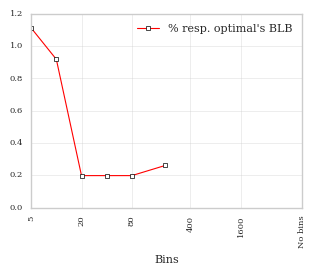

In [352]:
with matplotlib.style.context(paper_style):
    ax = plot_cost(df, "Periodic", 3000000, plot_phase_I=False)
    #ax.set_ylim(0,1)

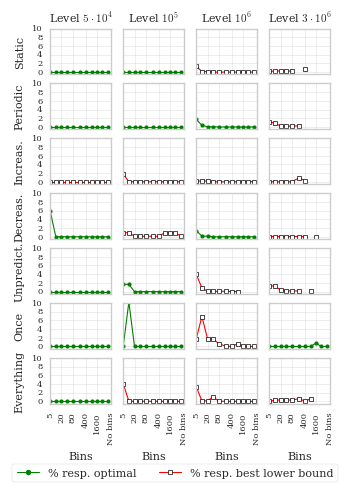

In [353]:
# Preparo qué casos quiero mostrar (y en qué orden)
casetitles = ["Static", "Periodic", "Increasing", "Decreasing",
              "Unpredictable", "Once", "Everything"]
levels = [5,10,100,300]

with matplotlib.style.context(paper_style):
    # Preparo un array de subplots
    f, axarr = plt.subplots (len(casetitles), len(levels), sharex=True, sharey=True, figsize=(15,30))

    # Hago el plot de cada caso, cada uno en su subplot correspondiente
    for i,case in enumerate(casetitles):
        for j,level in enumerate(levels):
            plot_cost(df, case, level*10000, ax=axarr[i,j],
                          plot_phase_I = False, legend=False)

    # Aumento el tamaño de la figura (por defecto muy pequeño)
    f.set_size_inches(3.5,5)
    #f.tight_layout()
    # f.suptitle("% Overcost resp. optimal or lower bound", y=1.03)

    # Pongo títulos a filas y columnas
    for ax, casetitle in zip(axarr[:,0], 
            ["Static", "Periodic", "Increas.", "Decreas.", "Unpredict.", "Once", "Everything"]
            ):
        ax.set_ylabel(casetitle, rotation=90)
        ax.set_ylim([-0.5,10])
    
    for ax, level in zip(axarr[0,:], ["5\cdot10^4", "10^5", "10^6", "3\cdot10^6" ]):
        ax.set_title("Level ${}$".format(level))
        ax.set_xlim(0,8760)
    patches0, labels = axarr[0,0].get_legend_handles_labels()
    patches1, labels = axarr[-1,-1].get_legend_handles_labels()
    patches = patches0 + patches1
    f.legend(patches, labels=["% resp. optimal", "% resp. best lower bound"], 
             bbox_to_anchor=(0.5, 0.05), loc="center",
             markerscale=1.3,
             ncol=2, shadow=False, fancybox=True, framealpha=1, 
             frameon=True)
    f.subplots_adjust(bottom=0.2, left=0.15,right=0.95, top=0.95)

# Plot of the workload cases

In [354]:
# Load all workloads from CSVs
cases = df.index.levels[0]            # Names of each case
dfw = pd.DataFrame()
for case in cases:
    data = pd.read_csv("../data/processed/traces_synthetic_{}_LTWP.csv".format(case.lower()),
                       index_col=0).T
    data["Case"] = case
    data["Level"] = data.index
    data.set_index(["Case", "Level"])
    dfw = dfw.append(data)
dfw = dfw.set_index(["Case", "Level"]).reindex().sort_index().T

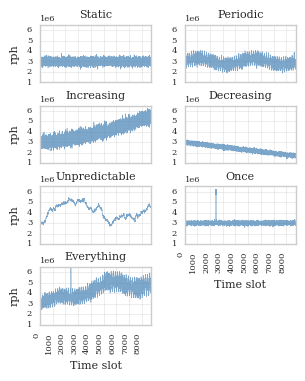

In [355]:
# Plot them all in a single graph (only for base_level=3000000)

# Workloads
k = dfw.loc[:, pd.IndexSlice[:, "3000000"]].astype(float)
k.index.name = "Time slot"
# Nombres de los casos
k.columns = k.columns.get_level_values(0)

# Force this given order in the subplots
selection = ["Static", "Periodic", "Increasing", 
             "Decreasing", "Unpredictable", "Once", "Everything"]

with matplotlib.style.context(paper_style):
    axarr = k[selection].plot(subplots=True, sharex=True, layout=(4,2),
                              lw=0.4, color="steelblue", alpha=0.7, legend=False, 
                              rot=90,
                              figsize=(3.3,5))#, fontsize=7)
    plt.subplots_adjust(left=None, bottom=0.3, right=None, top=None,
                        wspace=0.3,  hspace=0.4)
    for ax, title in zip(axarr.flat, selection):
        ax.set_title(title)#, fontsize=11)
        # Lo siguiente fuerza a usar notación científica
        ax.yaxis.get_major_formatter().set_powerlimits((0, 1))
        ax.set_ylim(1e6,6.5e6)
for ax in axarr[:,0]:
    ax.set_ylabel("rph", rotation=90)